# Time Series Tasks
## Import Data + Exploratory Analysis
### Checking for duplicates, NAs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

long = pd.read_csv('patient_longitudinal.csv', sep='\t')
long['visit_date'] = pd.to_datetime(arg=long['visit_date'], format='%Y-%m-%d')
print(long.duplicated().sum()) #checking for dupes

0


In [2]:
print(long.isna().sum()) #checking for NAs

patient_id       0
visit_date       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64


### Checking unique dates recorded in data

In [3]:
print(long['visit_date'].unique())

<DatetimeArray>
['2023-01-17 00:00:00', '2023-02-22 00:00:00', '2023-03-23 00:00:00',
 '2023-04-16 00:00:00', '2023-06-05 00:00:00', '2023-06-16 00:00:00',
 '2023-06-21 00:00:00', '2023-07-03 00:00:00', '2023-08-23 00:00:00',
 '2023-10-13 00:00:00', '2023-10-20 00:00:00', '2023-12-13 00:00:00',
 '2024-01-17 00:00:00', '2024-03-01 00:00:00', '2024-04-17 00:00:00',
 '2024-04-04 00:00:00', '2024-03-14 00:00:00', '2024-05-19 00:00:00',
 '2024-07-03 00:00:00', '2024-05-25 00:00:00', '2024-10-21 00:00:00',
 '2024-10-05 00:00:00', '2024-11-14 00:00:00', '2025-01-19 00:00:00',
 '2024-12-07 00:00:00', '2025-02-20 00:00:00', '2025-02-25 00:00:00',
 '2025-03-25 00:00:00', '2025-04-03 00:00:00', '2025-07-31 00:00:00',
 '2025-06-17 00:00:00', '2025-08-26 00:00:00', '2025-06-23 00:00:00',
 '2025-11-12 00:00:00', '2025-12-08 00:00:00', '2025-12-04 00:00:00',
 '2025-12-22 00:00:00', '2026-02-14 00:00:00', '2026-05-24 00:00:00',
 '2026-01-26 00:00:00', '2026-05-30 00:00:00', '2026-04-28 00:00:00',
 '20

## Visualizing Blood Pressure Data
### Plotting monthly averages

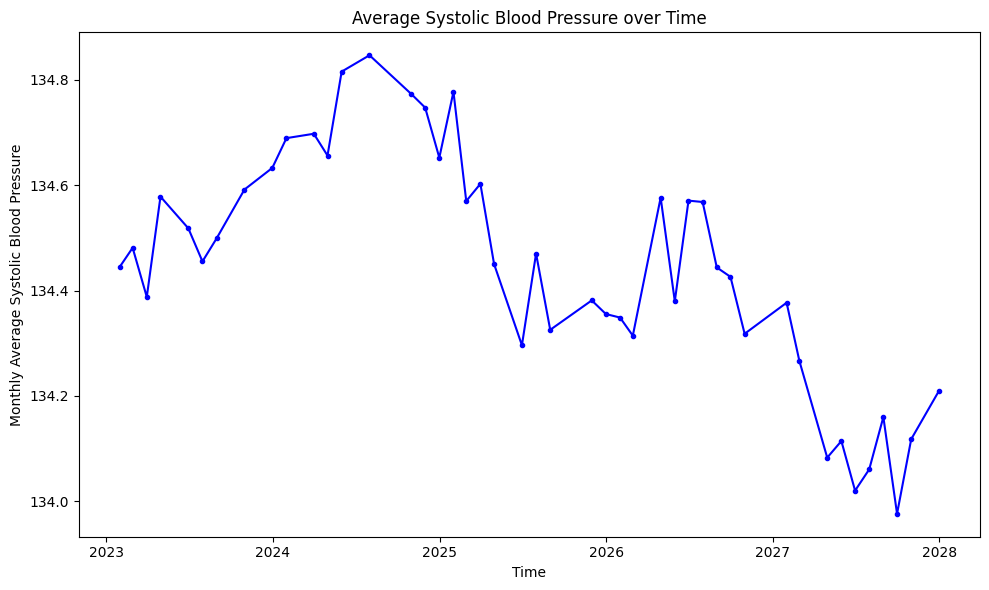

In [4]:
long_ts = long.set_index('visit_date')
long_ts = long_ts.resample('ME').mean() #resample timestamps to the end of the month for a monthly average
bp_ts = long_ts['bp_systolic'].dropna() #drop NA values for plotting

plt.figure(figsize=(10,6))
plt.plot(bp_ts.index.values, bp_ts, c='blue', marker='.')
plt.title('Average Systolic Blood Pressure over Time')
plt.xlabel('Time')
plt.ylabel('Monthly Average Systolic Blood Pressure')
plt.tight_layout()
plt.show()

### Plotting 3-month rolling averages

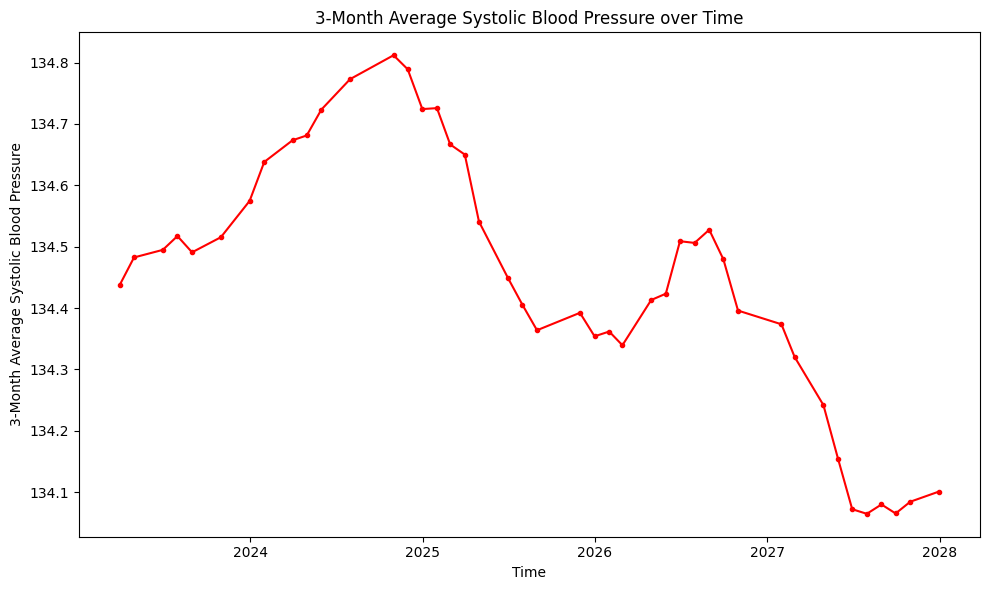

In [5]:
bp_rolling = bp_ts.rolling(window = 3).mean() # rolling averages for every 3 months

plt.figure(figsize=(10,6))
plt.plot(bp_rolling.index.values, bp_rolling, c='red', marker='.')
plt.title('3-Month Average Systolic Blood Pressure over Time')
plt.xlabel('Time')
plt.ylabel('3-Month Average Systolic Blood Pressure')
plt.tight_layout()
plt.show()

- Note: 3-month average values are based on the average of a month and the previous two months

# Statistical Modeling Tasks
## Analyze factors affecting baseline blood pressure

In [35]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

base = pd.read_csv('patient_baseline.csv', sep='\t')
x = base[['age', 'bmi', 'smoking', 'diabetes']]
y = base['bp_systolic']

print("\n=== Linear Regression ===")
x_const = sm.add_constant(x)
results = OLS(y, x_const).fit()
print(results.summary().tables[1])


=== Linear Regression ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.000     104.569     112.417
age            0.2840      0.023     12.551      0.000       0.240       0.328
bmi            0.2786      0.066      4.198      0.000       0.148       0.409
smoking        5.2412      0.698      7.512      0.000       3.872       6.610
diabetes       9.8732      0.742     13.307      0.000       8.417      11.329


- For each year older a patient is, systolic BP is predicted to increase by about 0.284 units
- For each point BMI increases, systolic BP is predicted to increase by about 0.279 units
- Smokers are predicted to have systolic BP values about 5.24 units higher
- Diabetic subjects are predicted to have systolic BP values about 9.87 units higher
- The p-values for all variables are less than 0.001, indicating that if there were no relationship between systolic BP and these variables, observing this data would be highly improbable

R-squared: 0.37646882997065023


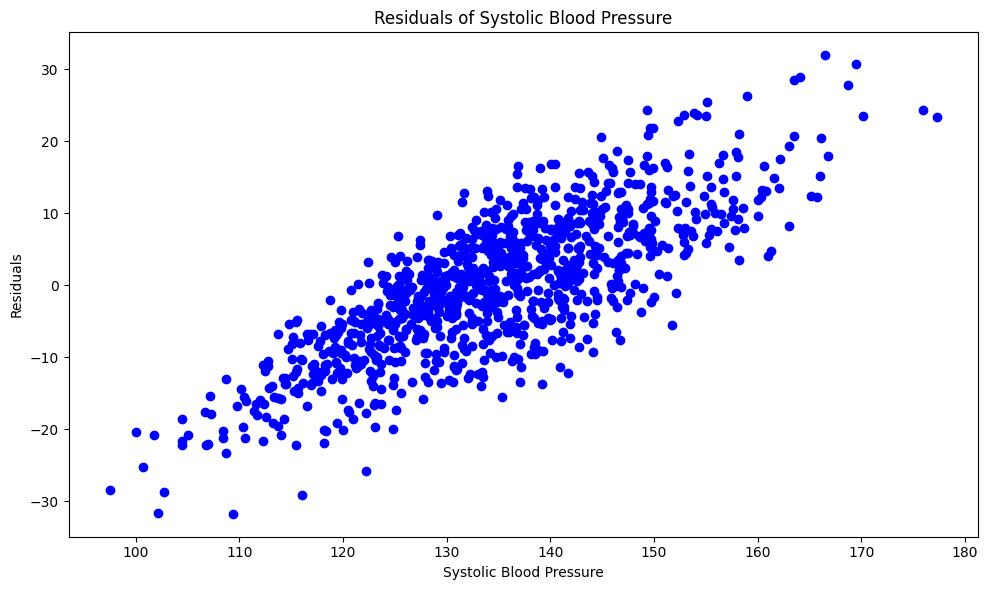

In [36]:
print('R-squared:', results.rsquared)

# plotting residuals
plt.figure(figsize=(10,6))
plt.scatter(base['bp_systolic'], results.resid, c='blue')
plt.title('Residuals of Systolic Blood Pressure')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

The residuals of the linear regression model tend to increase as the actual value of systolic blood pressure increases, indicating that the model tends to overestimate lower systolic BP levels and underestimate higher systolic BP levels. This trend, along with the very low R-squared value of about 0.15 indicates that this linear model using age, BMI, smoking status, and diabetes status is a very poor predictor of systolic BP levels.
## Model Treatment Effectiveness

In [45]:
treat = pd.read_csv('patient_treatment.csv', sep='\t')

x = treat[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
x_const = sm.add_constant(x)
y = treat['outcome']
glm_model = sm.GLM(y, x_const, family = sm.families.Binomial())
glm_results = glm_model.fit()
print('GLM coefficients:\n', glm_results.params, '\n')
print('Odds ratios:\n', np.exp(glm_results.params))

GLM coefficients:
 const       -1.268120
age          0.002740
bmi          0.029657
smoking     -0.388712
diabetes    -0.488660
adherence    0.122070
dtype: float64 

Odds ratios:
 const        0.281360
age          1.002744
bmi          1.030101
smoking      0.677929
diabetes     0.613448
adherence    1.129833
dtype: float64


Smokers and diabetic patients have between 0.6 to 0.7 times poorer odds of better outcomes. Patients who adhere to treatments have better odds of better outcomes. Age and BMI appear to not have a strong association with outcome in terms of odds of better outcomes.

In [58]:
# Residual deviance
resid_dev = glm_results.resid_deviance
resid_dev = np.square(resid_dev)
resid_dev = sum(resid_dev)
print('Residual Deviance:', resid_dev)

# Null deviance
null_dev = glm_results.null_deviance
print('Null Deviance:', null_dev)

print('\n', glm_results.summary())

Residual Deviance: 1312.83208852496
Null Deviance: 1331.9768185036037

                  Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Mon, 04 Nov 2024   Deviance:                       1312.8
Time:                        13:01:03   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

The similarity between the residual and null deviance indicates that this model is not very good at predicting patient outcome based on the variables that have been used (age, BMI, smoking status, diabetes status, treatment adhereence).